In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set.
y = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
type(y[0])

str

In [36]:
(session.query(Measurement.date).order_by(Measurement.date.desc()).first())[0]

'2017-08-23'

In [34]:
x = session.query(func.max(Measurement.date)).all()
type(x)
# x = str(x[0])
x

[('2017-08-23')]

In [43]:
dt.datetime.strptime((y[0]), "%Y%m%d").date()

ValueError: time data '2017-08-23' does not match format 'YYYY-mm-dd'

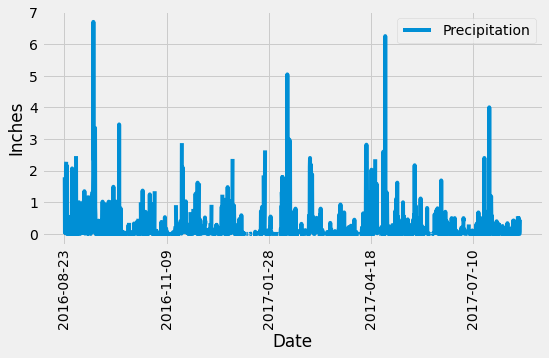

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set. 
#  try this to pass for year ago instead of manually entering date.  datetime.datetime.strptime('24052010', "%d%m%Y").date()
year_ago = dt.date(2017, 8, 23) - dt.timedelta(366)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(precip, columns=['date', 'prcp'])
data.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_data = data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_data.plot(figsize=(8,4))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"], loc='upper right')
plt.xticks(rotation='vertical')
plt.show()

In [12]:
sorted_data.head(-5)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-21,0.02
2017-08-21,0.00
2017-08-21,NaN


In [13]:
len(sorted_data)

2230

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
query = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
# desc_query = query.order_by(desc(Measurement.prcp)).all()
query

[('USC00513117', 2709),
 ('USC00518838', 511),
 ('USC00519523', 2669),
 ('USC00519281', 2772),
 ('USC00516128', 2612),
 ('USC00519397', 2724),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00517948', 1372)]

In [16]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [17]:
sorted_station = sorted(query, key=lambda x:int(x[1]), reverse=True)
most_active = sorted_station[0][0]
most_active
sorted_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
summary = session.query(Measurement.station, func.min(Measurement.prcp), func.max(Measurement.prcp), func.avg(Measurement.prcp)).filter(Measurement.station == most_active).all()
print(f'Most active station: {summary[0][0]} \nMin prcp: {summary[0][1]} \nMax prcp: {summary[0][2]} \nAvg prcp: {summary[0][3]}')

Most active station: USC00519281 
Min prcp: 0.0 
Max prcp: 9.64 
Avg prcp: 0.2123520923520915


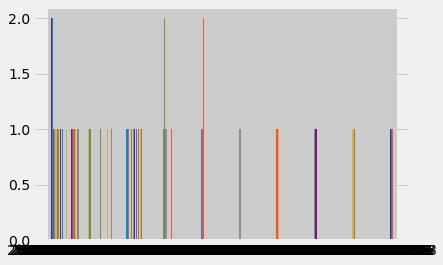

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_precip = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > year_ago).filter(Measurement.station == most_active).all()
ax = plt.hist(most_active_precip)



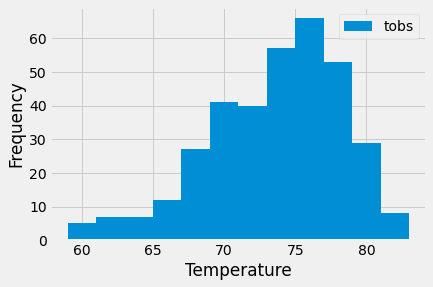

In [21]:
tobs = np.array(session.query(Measurement.tobs).filter(Measurement.date > year_ago).filter(Measurement.station == most_active).all())
# this didn't work well before because it was a list.  I figured out it needed to be an array and added 'np.array.
ax = plt.hist(tobs, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc='upper right')

In [22]:
#  this didn't work either when tobs was a list.  so it was a hint that i couldn't do some statistics with it.
tobs.min()

59.0

# Close session

In [217]:
# Close Session
session.close()

# This section is for testing out my Flask app code

In [23]:
prcp_data = []
for date, prcp in precip:
    prcp_dict = {}
    prcp_dict['date'] = date
    prcp_dict['prcp'] = prcp
    prcp_data.append(prcp_dict)
    


In [24]:
stations_list = session.query(Station.station).all()
stations_list

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [25]:
query = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()
most_active = (sorted(query, key=lambda x :int(x[1]), reverse=True))[0][0]
most_active

'USC00519281'

In [38]:
# start = 2015-3-1
# end = 2016-4-1
query2 = session.query(Measurement.date, func.min(Measurement.tobs),\
         func.max(Measurement.tobs), func.avg(Measurement.tobs))\
            .filter(Measurement.date >= "2017-06-01").all() 
    
query2    

[('2017-07-03', 69.0, 87.0, 78.04201680672269)]

In [34]:
session.query(func.min(Measurement.tobs),\
         func.max(Measurement.tobs), func.avg(Measurement.tobs))\
            .filter(Measurement.date >= 2017-6-30).all()

[(53.0, 87.0, 73.09795396419437)]